In [1]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress
from adjustText import adjust_text
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm


## Read Data

In [2]:
tweets = pd.read_csv('../Data/new_tweets.csv')
revenue = pd.read_csv('../Data/new_titles_performance.csv')
movies = pd.read_csv('../Data/new_movie_details.csv')

tweets = tweets.loc[:, ~tweets.columns.str.contains('^Unnamed')]
revenue = revenue.loc[:, ~revenue.columns.str.contains('^Unnamed')]
movies = movies.loc[:, ~movies.columns.str.contains('^Unnamed')]

In [3]:
tweets.head()

,ID,title,post_link,post_date_time,post_content,user_name,user_bio,user_followers_count,user_followee_count,user_post_count,...,state,language,post_date,week_num,year_week,content_clean,polarity_score,content_notitle,polarity_score_notitle,index
0,1,Beauty and the Beast,http://twitter.com/isabellabarila/status/87564...,2017-06-16T09:21:34.000+0000,After watching the new Beauty and the Beast it...,isabellabarila,love me some big ass gold hoops,61,200,1118,...,South Australia,en,2017-06-16,24,2017_24,After watching the new Beauty and the Beast it...,0.5859,After watching new it has only further confirm...,0.0000,0
1,1,Beauty and the Beast,http://twitter.com/itrapful/status/87588081932...,2017-06-17T01:00:35.000+0000,RT @Moviepicts Beauty and the Beast (1991)/Bea...,itrapful,Aussie | your girl probably follows me | #7 ⚽️...,39222,3230,2163,...,Victoria,en,2017-06-17,24,2017_24,RT Beauty and the Beast (1991)/Beauty and the ...,0.5859,RT (1991)/Beauty (2017),0.0000,1
2,1,Beauty and the Beast,http://twitter.com/rulesofcaylen/status/875873...,2017-06-17T00:30:29.000+0000,does anyone know where i can watch beauty and ...,rulesofcaylen,someone write me a bio,5317,1480,89497,...,Queensland,en,2017-06-17,24,2017_24,does anyone know where i can watch beauty and ...,0.5859,does anyone know where i can watch online? my ...,0.0000,2
3,1,Beauty and the Beast,http://twitter.com/ajsalvatore02/status/875868...,2017-06-17T00:12:43.000+0000,RT @beourguest Watch #BeautyAndTheBeast for ev...,ajsalvatore02,"Teen Wolf, The 100, Shadow hunters,The Vampire...",554,599,5577,...,Victoria,en,2017-06-17,24,2017_24,RT Watch #BeautyAndTheBeast for evermore. The ...,0.0000,RT Watch #BeautyAndTheBeast for evermore. live...,0.0000,3
4,1,Beauty and the Beast,http://twitter.com/FilmMomatic/status/87590622...,2017-06-17T02:41:32.000+0000,@RealJDDuran The live-action director's cut of...,FilmMomatic,"Certified @RottenTomatoes film critic, yet the...",555,1686,11685,...,New South Wales,en,2017-06-17,24,2017_24,The live-action director's cut of BEAUTY AND T...,0.5319,live-action director's cut of (1991). So unnec...,-0.2732,4


In [4]:
revenue.head()

,title,date_range,year,rank,weekend_gross,gross_to_date,week_no_release,format_date,adj_gtd,shift,week_gross,week_num,year_week,weekend_perc,perc_change
0,Incredibles 2,Jun. 14–17,2018.0,1,7898856.0,7898856.0,1,2018-06-14,7898856,0.0,7898856.0,24,2018_24,100.000000,NaN
1,Incredibles 2,Jun. 21–24,2018.0,2,4868158.0,14708509.0,2,2018-06-21,14708509,7898856.0,6809653.0,25,2018_25,71.489076,86.210623
2,Incredibles 2,Jun. 28–Jul. 1,2018.0,2,3253530.0,19313351.0,3,2018-06-28,19313351,14708509.0,4604842.0,26,2018_26,70.654541,31.307334
3,Incredibles 2,Jul. 5–8,2018.0,2,2940132.0,24578641.0,4,2018-07-05,24578641,19313351.0,5265290.0,27,2018_27,55.839887,27.262436
4,Incredibles 2,Jul. 12–15,2018.0,2,2586378.0,29501312.0,5,2018-07-12,29501312,24578641.0,4922671.0,28,2018_28,52.540135,20.028247


## 1. Correlation between Tweets and Revenue

Compare count of tweets per movie to its revenue.

Get its correlation coefficient, p value and scatter plot

In [5]:
#get df for tweets to merge with revenue 
tweet_total_count = tweets.groupby('title', as_index=False)['index'].count()
tweet_total_count = tweet_total_count.rename(columns={'index': 'tweet_count'})

#get df for revenue
revenue_total_count = revenue.groupby('title', as_index=False)['week_gross'].sum()
revenue_total_count = revenue_total_count.rename(columns={'week_gross': 'total_gross'})

#merge df - inner
tweet_revenue_df = pd.merge(tweet_total_count, revenue_total_count, \
                            left_on='title', right_on='title', how = 'inner')
print("size of tweet_rev_df is: " + str(len(tweet_revenue_df)))

tweet_revenue_df.head()


size of tweet_rev_df is: 19


,title,tweet_count,total_gross
0,Avengers Infinity War,4028,46825158.0
1,Beauty and the Beast,4103,36309005.0
2,Black Panther,13442,31939868.0
3,Coco,1834,9129986.0
4,Dunkirk,6540,18551532.0


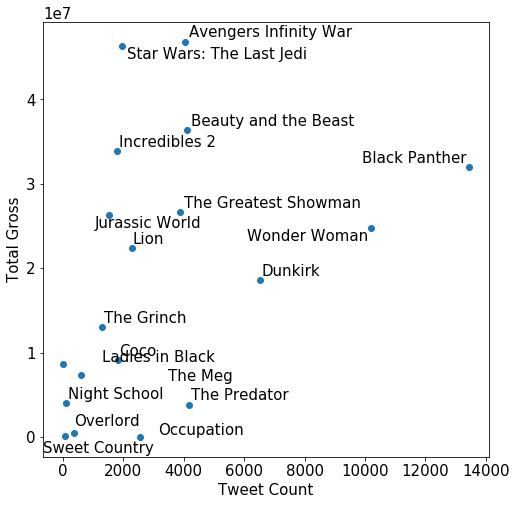

LinregressResult(slope=1727.5231868039566, intercept=13457351.330671482, rvalue=0.3976727889579096, pvalue=0.09177613780483376, stderr=966.7018421449144)

In [6]:
# Correlation between tweet counts and week gross
matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tweet_revenue_df['tweet_count'], tweet_revenue_df['total_gross'])
texts = []
for i, txt in enumerate(tweet_revenue_df.title):
    texts.append(ax.text(tweet_revenue_df.tweet_count.iat[i], tweet_revenue_df.total_gross.iat[i], txt))
    
adjust_text(texts)

plt.xlabel("Tweet Count")
plt.ylabel("Total Gross")
plt.show()


x = tweet_revenue_df['tweet_count']
y = tweet_revenue_df['total_gross']

linregress(x, y)#same results as Pearsons correlation
#tweet_revenue_df

#### Results - 1. Correlation between Tweets and Revenue

- Correlation coefficient of 0.397 (positive but not a strong correlation)
- Sample size is 19
- pvalue >0.05 may not be significant at 95%.  Nonetheless, pvalue<0.1, so 90% chance of it being accurate. 

- This result is not very useful. 

## 2. Correlation between Tweets (consider User Followers) and Revenue

In the results above, each tweet is treated the same way. However, different twitter users have different outreach of users. Hence I will multiply each tweet by the number of followers the user has. 

Caveats: If a follower has 10 followers, it does not mean all of its followers saw the tweets. But we will assume they do and see how our results fare. 


Get its correlation coefficient, p value and scatter plot

In [7]:
#get df for tweets to merge with revenue 
tweet_view_count = tweets.groupby('title', as_index=False)['user_followers_count'].sum()
tweet_view_count = tweet_view_count.rename(columns={'user_followers_count': 'tweet_views'})
tweet_view_count.head()

tweetviews_revenue_df = pd.merge(tweet_view_count, revenue_total_count, \
                                 left_on='title', right_on='title', how = 'inner')
print("size of tweetviews_rev_df is: " + str(len(tweetviews_revenue_df)))

tweetviews_revenue_df.head()

size of tweetviews_rev_df is: 19


,title,tweet_views,total_gross
0,Avengers Infinity War,12385452,46825158.0
1,Beauty and the Beast,16758465,36309005.0
2,Black Panther,30420519,31939868.0
3,Coco,5237246,9129986.0
4,Dunkirk,23458300,18551532.0


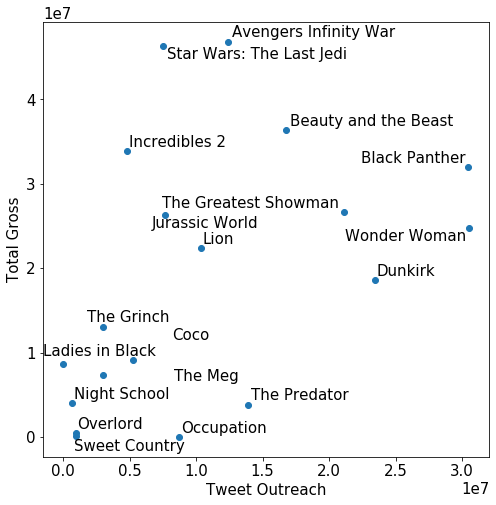

LinregressResult(slope=0.7003517442242074, intercept=11548946.38900007, rvalue=0.44420167877674765, pvalue=0.056738125878352766, stderr=0.3425974265789765)

In [8]:
# Correlation between tweet counts and week gross
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tweetviews_revenue_df['tweet_views'], tweetviews_revenue_df['total_gross'])
texts = []
for i, txt in enumerate(tweetviews_revenue_df.title):
    texts.append(ax.text(tweetviews_revenue_df.tweet_views.iat[i], tweetviews_revenue_df.total_gross.iat[i], txt))
    
adjust_text(texts)

plt.xlabel("Tweet Outreach")
plt.ylabel("Total Gross")
plt.show()


x = tweetviews_revenue_df['tweet_views']
y = tweetviews_revenue_df['total_gross']

linregress(x, y)#same results as Pearsons correlation

#### Results - 2. Correlation between Tweets and Revenue

- Correlation coefficient of 0.444 (positive but not a strong correlation, >0.5 moderately correlated)
- Sample size is 17
- pvalue <0.05 so 95% chance of it being accurate. 

- This result shows slightly stronger correlation than before

###  Breakdown by Budget

Movies that with budget above $150 million will be classified as high budget, and analysed separately with those non high budget

High Budget Films



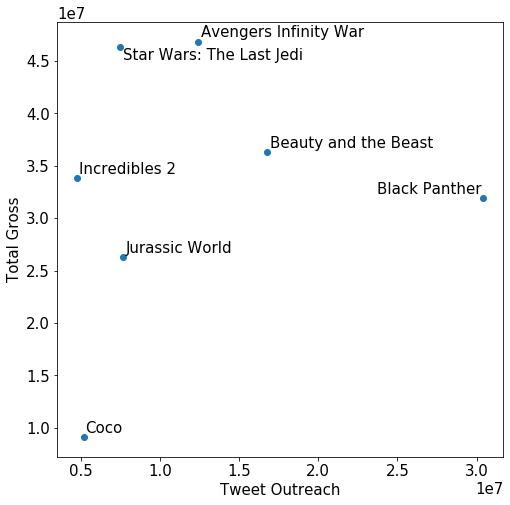

LinregressResult(slope=0.2515871857937684, intercept=29911174.953635484, rvalue=0.1779790821078587, pvalue=0.7026159840112137, stderr=0.622077904890389)

In [9]:
print("High Budget Films")
print()
high_budget_mov = movies.loc[movies['budget_mil']>=150]
high_budget_lst = list(high_budget_mov.title.unique())

# Correlation between tweet counts and week gross
fig, ax = plt.subplots(figsize=(8, 8))
high_budget_df = tweetviews_revenue_df.loc[tweetviews_revenue_df['title'].isin(high_budget_lst)]

ax.scatter(high_budget_df['tweet_views'], high_budget_df['total_gross'])
texts = []
for i, txt in enumerate(high_budget_df.title):
    texts.append(ax.text(high_budget_df.tweet_views.iat[i], high_budget_df.total_gross.iat[i], txt))
    
adjust_text(texts)

plt.xlabel("Tweet Outreach")
plt.ylabel("Total Gross")
plt.show()

x = high_budget_df['tweet_views']
y = high_budget_df['total_gross']
linregress(x, y)#same results as Pearsons correlation

#high_budget_df

Low Budget Films



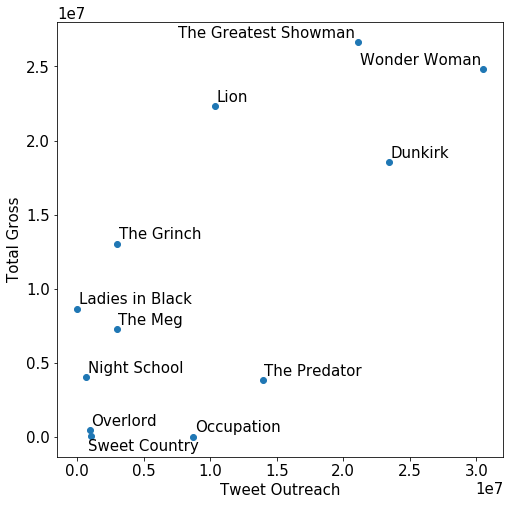

LinregressResult(slope=0.7075421256574485, intercept=3937606.9118159525, rvalue=0.7373690405066341, pvalue=0.0062057545976759295, stderr=0.2049681598237299)

In [10]:
print("Low Budget Films")
print()
# Correlation between tweet counts and week gross
fig, ax = plt.subplots(figsize=(8, 8))
low_budget_df = tweetviews_revenue_df.loc[~tweetviews_revenue_df['title'].isin(high_budget_lst)]

ax.scatter(low_budget_df['tweet_views'], low_budget_df['total_gross'])
texts = []
for i, txt in enumerate(low_budget_df.title):
    texts.append(ax.text(low_budget_df.tweet_views.iat[i], low_budget_df.total_gross.iat[i], txt))
    
adjust_text(texts)

plt.xlabel("Tweet Outreach")
plt.ylabel("Total Gross")
plt.show()

x = low_budget_df['tweet_views']
y = low_budget_df['total_gross']
linregress(x, y)#same results as Pearsons correlation

#low_budget_df


#### Result - Breakdown by Budget

Among high budget films, there is no strong correlation and results are not statistically significant
Among low budget films, we have a postivie correlation>0.7, and pvalue<0.05. Hence there is a moderately strong positive correlation and at least 95% accurate.

### Breakdown by Film Release Timing

8/19 movies were released during holiday season

Holiday Films



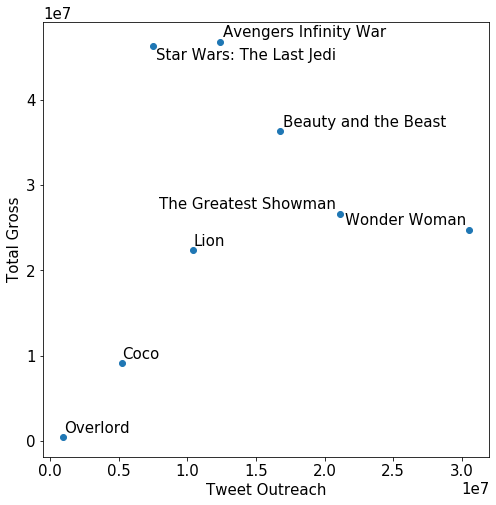

LinregressResult(slope=0.5490519363394727, intercept=19418862.337480124, rvalue=0.315725840367515, pvalue=0.44617812369351884, stderr=0.6736362452432747)

In [11]:
print("Holiday Films")
print()
hol_mov = movies.loc[movies['holiday_season']==1]
hol_lst = list(hol_mov.title.unique())


# Correlation between tweet counts and week gross
fig, ax = plt.subplots(figsize=(8, 8))
hol_df = tweetviews_revenue_df.loc[tweetviews_revenue_df['title'].isin(hol_lst)]

ax.scatter(hol_df['tweet_views'], hol_df['total_gross'])
texts = []
for i, txt in enumerate(hol_df.title):
    texts.append(ax.text(hol_df.tweet_views.iat[i], hol_df.total_gross.iat[i], txt))
    
adjust_text(texts)

plt.xlabel("Tweet Outreach")
plt.ylabel("Total Gross")
plt.show()


x = hol_df['tweet_views']
y = hol_df['total_gross']

linregress(x, y)#same results as Pearsons correlation

#hol_df

Non Holiday Films



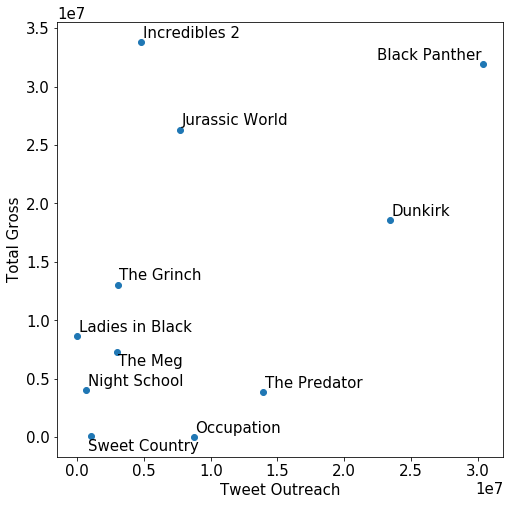

LinregressResult(slope=0.5921991046810129, intercept=8217979.675032926, rvalue=0.4751752245328918, pvalue=0.1396591053274459, stderr=0.3655288603363627)

In [12]:
print("Non Holiday Films")
print()

# Correlation between tweet counts and week gross
fig, ax = plt.subplots(figsize=(8, 8))
not_hol_df = tweetviews_revenue_df.loc[~tweetviews_revenue_df['title'].isin(hol_lst)]

ax.scatter(not_hol_df['tweet_views'], not_hol_df['total_gross'])
texts = []
for i, txt in enumerate(not_hol_df.title):
    texts.append(ax.text(not_hol_df.tweet_views.iat[i], not_hol_df.total_gross.iat[i], txt))
    
adjust_text(texts)

plt.xlabel("Tweet Outreach")
plt.ylabel("Total Gross")
plt.show()


x = not_hol_df['tweet_views']
y = not_hol_df['total_gross']

linregress(x, y)#same results as Pearsons correlation

#not_hol_df

#### Result - Breakdown by Release Timing

Results from both groups statistically significant.



## 3. Correlation between Tweets and Revenue (first 8 weeks, per movie)

After some descriptive analytics, it is observed that some movies have some random spike more than 2 months after the release of movie, which is likely to be noise. Also, box office success can likely be determined by its performance within 2 months of release, as new movies are often release and people simply forget the older movies. 

Instead of comparing between the movies, we will compare between weeks for each movie. Within each movie, visually we do see some form of correlation between tweets and weekly gross. 

Get its correlation coefficient, p value and scatter plot

In [13]:
#Only revenue data contains number of weeks since release. Need to do some preprocessing here first
#let rev be the dataframe containing only first 8 weeks of release revenue

rev = revenue.loc[revenue['week_no_release']<=8]
rev['movie_week_index'] = rev['title'] + "_" + rev['year_week'] #create new index to map to tweets data
movie_week_lst = rev['movie_week_index'].unique()
#rev.head()

twt = tweets.copy()
twt['movie_week_index'] = twt['title'] + '_' + twt['year_week']
twt = twt.loc[twt['movie_week_index'].isin(movie_week_lst)] #filter for tweets from firts 8 weeks of release
#twt.head()

##note: Some movies i.e Sweet Country filtered out, dont have data for first 8 weeks.


In [14]:
#get df for tweets to merge with revenue 
twt_total_count = twt.groupby(['title', 'year_week'], as_index=False)['index'].count()
twt_total_count = twt_total_count.rename(columns={'index': 'tweet_count'})

#get df for revenue
rev_total_count = rev.groupby(['title', 'year_week'], as_index=False)['week_gross'].sum()

#merge df - inner
twt_rev_df = pd.merge(twt_total_count, rev_total_count, \
                      left_on=['title', 'year_week'], right_on=['title', 'year_week'], how = 'inner')
print("size of twt_rev_df is: " + str(len(twt_rev_df)))

twt_rev_df.head()


size of twt_rev_df is: 107


,title,year_week,tweet_count,week_gross
0,Avengers Infinity War,2018_17,1460,22698063.0
1,Avengers Infinity War,2018_18,912,11699501.0
2,Avengers Infinity War,2018_19,283,6102927.0
3,Avengers Infinity War,2018_20,148,2473468.0
4,Avengers Infinity War,2018_21,58,1528745.0


#### i.e Beauty and the Beast, correlation with data points across the weeks

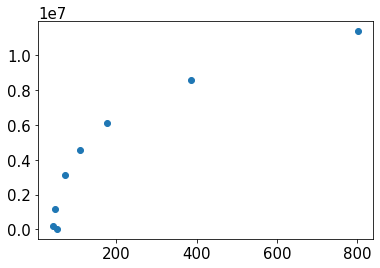

LinregressResult(slope=14053.46410024724, intercept=1424310.3918353016, rvalue=0.9044215187319646, pvalue=0.0020293496210047695, stderr=2706.4404718879136)

In [15]:
# Correlation between tweet counts and week gross for Beauty and the Beast

sub_df = twt_rev_df.loc[twt_rev_df['title'] == 'Beauty and the Beast']
sub_df.head(20)

x = sub_df['tweet_count']
y = sub_df['week_gross']

plt.scatter(x, y)
plt.show()

linregress(x, y) #same results as Pearsons correlation

#### Results for Beauty and the Beast
- 8 Data points only
- Correlation = 0.9
- pvalue <0.05 : 95% accurate
    
### Now check for all movies

In [16]:
mov_lst = twt_rev_df.title.unique().tolist()

def get_corr_results(df):
    x = df['tweet_count']
    y = df['week_gross']
    
    size = len(df)
    slope, intercept, rval, pval, stderr = linregress(x, y)
    return [size, rval, pval]

header_lst = ['title', 'sample_size', 'corr_coeff', 'pval']
df_lst = [header_lst]
for mov in mov_lst:
    df = twt_rev_df.loc[twt_rev_df['title'] == mov]
    lst = [mov]
    lst.extend(get_corr_results(df))
    df_lst.append(lst)
    
#convert out list of list df_lst into data frame to see results
column_names = df_lst.pop(0)
df = pd.DataFrame(df_lst, columns=column_names)
df

,title,sample_size,corr_coeff,pval
0,Avengers Infinity War,8,0.986038,0.000007
1,Beauty and the Beast,8,0.904422,0.002029
2,Black Panther,8,0.763435,0.027503
3,Coco,5,0.663613,0.222006
4,Dunkirk,8,0.825001,0.011701
5,Incredibles 2,8,0.842718,0.008616
6,Jurassic World,8,0.976390,0.000032
7,Night School,8,0.661285,0.074143
8,Overlord,2,1.000000,0.000000
9,Star Wars: The Last Jedi,8,0.923314,0.001064


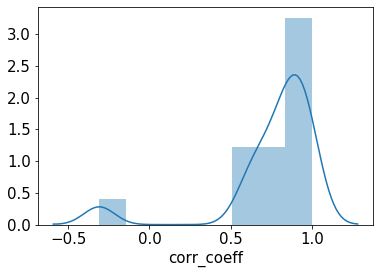

In [17]:
x = df['corr_coeff']
sns.distplot(x);

#### Results - 3. Correlation between Tweets and Revenue (first 8 weeks, per movie)

For most of the movies, with only sample size 8 (since we want to look at first 8 weeks), we see high positivie correlation coefficient>0.8 and mostly with p value<0.05, hence results are significant. 

For movies such as Overlord, Coco, The Grinch, results are not significant.

## 4. Correlation between Tweets and % Revenue Change (first 8 weeks, per movie)

As the weeks go, it is expected that the number of movie goers decrease, hence we are interested to see the percentage change from weekend to weekend. 


In [18]:
#get df for tweets to merge with revenue 
twt_total_count = twt.groupby(['title', 'year_week'], as_index=False)['index'].count()
twt_total_count = twt_total_count.rename(columns={'index': 'tweet_count'})

#get df for revenue
revchange_total_count = rev.groupby(['title', 'year_week'], as_index=False)['perc_change'].sum()

#merge df - inner
twt_revchange_df = pd.merge(twt_total_count, revchange_total_count,\
                            left_on=['title', 'year_week'], right_on=['title', 'year_week'], how = 'inner')
print("size of twt_rev_df is: " + str(len(twt_revchange_df)))

twt_revchange_df.head()


size of twt_rev_df is: 107


,title,year_week,tweet_count,perc_change
0,Avengers Infinity War,2018_17,1460,0.000000
1,Avengers Infinity War,2018_18,912,51.544050
2,Avengers Infinity War,2018_19,283,17.742323
3,Avengers Infinity War,2018_20,148,6.107254
4,Avengers Infinity War,2018_21,58,3.557375


In [19]:
mov_lst = twt_revchange_df.title.unique().tolist()

def get_corr_results(df):
    x = df['tweet_count']
    y = df['perc_change']
    
    size = len(df)
    slope, intercept, rval, pval, stderr = linregress(x, y)
    return [size, rval, pval]

header_lst = ['title', 'sample_size', 'corr_coeff', 'pval']
df_lst = [header_lst]
for mov in mov_lst:
    df = twt_revchange_df.loc[twt_revchange_df['title'] == mov] #this df overwrites previous one, be careful
    lst = [mov]
    lst.extend(get_corr_results(df))
    df_lst.append(lst)
    
#convert out list of list df_lst into data frame to see results
column_names = df_lst.pop(0)
df = pd.DataFrame(df_lst, columns=column_names)
df



,title,sample_size,corr_coeff,pval
0,Avengers Infinity War,8,0.337650,0.413379
1,Beauty and the Beast,8,0.174512,0.679372
2,Black Panther,8,0.939766,0.000522
3,Coco,5,-0.316971,0.603284
4,Dunkirk,8,0.120846,0.775610
5,Incredibles 2,8,0.290388,0.485357
6,Jurassic World,8,0.441567,0.273389
7,Night School,8,0.013157,0.975333
8,Overlord,2,-1.000000,0.000000
9,Star Wars: The Last Jedi,8,0.123282,0.771178


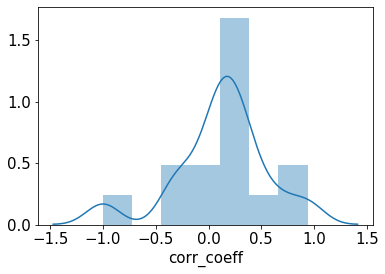

In [20]:
x = df['corr_coeff']
sns.distplot(x);

#### Results - 4. Correlation between Tweets and % Revenue Change (first 8 weeks, per movie)

Only Black Panther and Wonder Woman has a stronger positive correlation coefficient. Previousy in Results 3, we saw that Beauty and the Beast had corr_coeff of 0.904422 and pvalue of 0.002029. Based on the results here, we see a corr_coeff of only 0.174512. Hence we cannot conclude that tweets have a strong correlation with revenue. 

Also, note that we cannot take the average of corr coefficients. 
See: https://www.researchgate.net/post/average_of_Pearson_correlation_coefficient_values
However, we can plot out the distribution of corr_coeff and identify wheres the mean. As seen in plot above, most corr_coeff falls between 0 and 0.5, hence we cant find much corelation. Also, since theres only 13 movies here, results are not significant. 

## 5. Correlation between Tweet Polarity and % Revenue Change (first 8 weeks, per movie)

Polarity of tweets may have an effect on box office sales

In [21]:
tweet_sentiment = tweets.groupby(['title', 'year_week'], as_index=False)['polarity_score_notitle'].mean()
tweet_sentiment = tweet_sentiment.rename(columns={'polarity_score_notitle': 'tweet_polarity'})
#tweet_sentiment.head()

#get df for revenue, same as before
revchange_total_count = rev.groupby(['title', 'year_week'], as_index=False)['perc_change'].sum()

#merge df - inner
twtSen_revchange_df = pd.merge(tweet_sentiment, revchange_total_count, \
                               left_on=['title', 'year_week'], right_on=['title', 'year_week'], how = 'inner')

twtSen_revchange_df.head()


,title,year_week,tweet_polarity,perc_change
0,Avengers Infinity War,2018_17,0.175416,0.000000
1,Avengers Infinity War,2018_18,0.154104,51.544050
2,Avengers Infinity War,2018_19,0.057450,17.742323
3,Avengers Infinity War,2018_20,0.236399,6.107254
4,Avengers Infinity War,2018_21,0.173541,3.557375


In [22]:
mov_lst = twtSen_revchange_df.title.unique().tolist()

def get_corr_results(df):
    x = df['tweet_polarity']
    y = df['perc_change']
    
    size = len(df)
    slope, intercept, rval, pval, stderr = linregress(x, y)
    return [size, rval, pval]

header_lst = ['title', 'sample_size', 'corr_coeff', 'pval']
df_lst = [header_lst]
for mov in mov_lst:
    df = twtSen_revchange_df.loc[twtSen_revchange_df['title'] == mov] #df overwrites previous one, be careful
    lst = [mov]
    lst.extend(get_corr_results(df))
    df_lst.append(lst)
    
#convert out list of list df_lst into data frame to see results
column_names = df_lst.pop(0)
df = pd.DataFrame(df_lst, columns=column_names)

df

,title,sample_size,corr_coeff,pval
0,Avengers Infinity War,8,-0.431099,0.286253
1,Beauty and the Beast,8,0.618123,0.102394
2,Black Panther,8,0.182700,0.664984
3,Coco,5,-0.293886,0.631271
4,Dunkirk,8,-0.052071,0.902543
5,Incredibles 2,8,0.176489,0.675890
6,Jurassic World,8,-0.143058,0.735403
7,Night School,8,0.408368,0.315178
8,Overlord,2,1.000000,0.000000
9,Star Wars: The Last Jedi,8,0.217859,0.604256


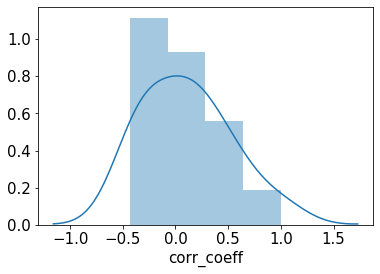

In [23]:
x = df['corr_coeff']
sns.distplot(x);

#### Results - 5. Correlation between Tweet Polarity and % Revenue Change (first 8 weeks, per movie)

Again, we do not see any strong correlation between the polarity of tweet and revenue changes. 

This is not surprising given that we only have 8 data points per correlation. If we can ensure less noise in the tweets, then we may extend beyond 8 data points and get better results. 



## 6. Going beyond Correlation, to Regression. 

All the analysis above can be conducted differently, if we further segment our dataset. i.e comparing the correlation of tweet counts and revenue, for movies with high and low budget. Alternatively, we can compare it against the genre of movies. There are many directions that we can explore. We can use regression to understand how different factor may affect tweet counts, and box office success


### Correlation 
Correlation only tells us co-relationship or association of two variables, and its used to represent linear relationship between two variables.

### Regression 
Regression describes how an independent variable is numerically related to the dependent variable. In reality, even if we do observe correlation between Social Media Buzz and Box Office Success (problem statement), results are rendered useless if there are confounding variables not taken into account. There are other variables related to the movies(type of movie, actors featured) that may affect how much people tweet and whether or not they hit the cinemas. 

Hence, exploring regression may give us more insights beyond just looking at a singular correlation coefficient value. 

Dependent Variable = Take max gross to date value. If we take first 8 weeks only, we will only have 13 data points instead of 17.

In [24]:
movies.head()

,index,title,release_date,year_num,holiday_season,studio,australian_film,rated,adaptation,franchise,...,Western,Adventure,Crime,History,Mystery,Music,Family,Musical,Animation,Thriller
0,1.0,Incredibles 2,6/14/18,2018_24,0.0,Disney,0.0,PG,0.0,1.0,...,0,1,0,0,0,0,1,0,1,0
1,2.0,Beauty and the Beast,3/23/17,2017_12,1.0,Disney,0.0,PG,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
2,3.0,The Greatest Showman,12/26/17,2017_52,1.0,Fox,0.0,PG,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,4.0,Black Panther,2/15/18,2018_07,0.0,Disney,0.0,PG-13,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,5.0,Avengers Infinity War,4/25/18,2018_17,1.0,Disney,0.0,PG-13,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
#drop columns that we dont need
drop_col = ['index','release_date', 'year_num', 'studio', 'rated', 'genre_list']
movies_df = movies.drop(drop_col, axis = 1)


In [26]:
#Add total tweet count 
movies_df = pd.merge(movies_df, tweet_total_count,\
                            left_on=['title'], right_on=['title'], how = 'left')

#Add total tweet count x user_followers for 8 weeks
movies_df = pd.merge(movies_df, tweet_view_count,\
                            left_on=['title'], right_on=['title'], how = 'left')

#Add tweet polarity
tweet_sentiment = tweets.groupby('title', as_index=False)['polarity_score_notitle'].mean()
movies_df = pd.merge(movies_df, tweet_sentiment,\
                            left_on=['title'], right_on=['title'], how = 'left')
#Consider weighting polarity according to user follower count

#Add box office
max_revenue = revenue.groupby(['title'] , as_index=False)['adj_gtd'].max()
movies_df = pd.merge(movies_df, max_revenue,\
                            left_on=['title'], right_on=['title'], how = 'left')



In [27]:
movies_df.head()

,title,holiday_season,australian_film,adaptation,franchise,budget_mil,Bunya,Disney,Fox,PPI,...,Mystery,Music,Family,Musical,Animation,Thriller,tweet_count,tweet_views,polarity_score_notitle,adj_gtd
0,Incredibles 2,0.0,0.0,0.0,1.0,200.0,0.0,1.0,0.0,0.0,...,0,0,1,0,1,0,1786,4787392,0.183416,33838139
1,Beauty and the Beast,1.0,0.0,1.0,0.0,160.0,0.0,1.0,0.0,0.0,...,0,0,1,1,0,0,4103,16758465,0.312795,36309005
2,The Greatest Showman,1.0,0.0,0.0,0.0,84.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,3877,21090965,0.341210,26670991
3,Black Panther,0.0,0.0,1.0,0.0,202.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,13442,30420519,0.247699,31939868
4,Avengers Infinity War,1.0,0.0,0.0,1.0,316.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,4028,12385452,0.151043,46825158


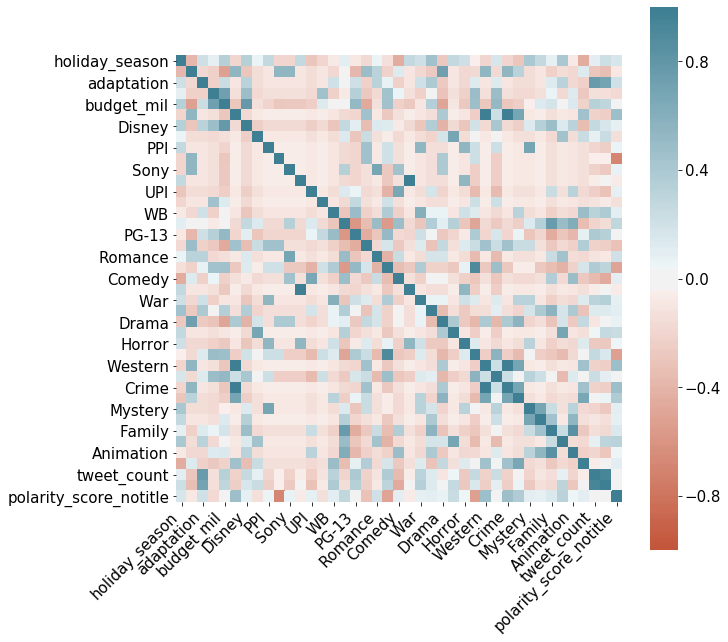

In [28]:
data = movies_df.drop(['title', 'adj_gtd'], axis = 1)
corr = data.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#not much use here LOL, just fyi

In [29]:
#scale x values
scaler = MinMaxScaler()
column_names_to_normalize = ['budget_mil', 'tweet_count', 'tweet_views']
movies_df[column_names_to_normalize] = scaler.fit_transform(movies_df[column_names_to_normalize])
movies_df.head()

,title,holiday_season,australian_film,adaptation,franchise,budget_mil,Bunya,Disney,Fox,PPI,...,Mystery,Music,Family,Musical,Animation,Thriller,tweet_count,tweet_views,polarity_score_notitle,adj_gtd
0,Incredibles 2,0.0,0.0,0.0,1.0,0.625000,0.0,1.0,0.0,0.0,...,0,0,1,0,1,0,0.132544,0.156741,0.183416,33838139
1,Beauty and the Beast,1.0,0.0,1.0,0.0,0.496795,0.0,1.0,0.0,0.0,...,0,0,1,1,0,0,0.304979,0.549091,0.312795,36309005
2,The Greatest Showman,1.0,0.0,0.0,0.0,0.253205,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0.288160,0.691088,0.341210,26670991
3,Black Panther,0.0,0.0,1.0,0.0,0.631410,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1.000000,0.996862,0.247699,31939868
4,Avengers Infinity War,1.0,0.0,0.0,1.0,0.996795,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.299397,0.405767,0.151043,46825158


#### Multiple Linear Regression


In [30]:
model = LinearRegression()
x = movies_df.drop(columns=['title', 'adj_gtd'])
y = movies_df['adj_gtd']

rfe = RFE(model, 10) 
rfe = rfe.fit(x, y)
f = rfe.get_support(1) #the most important features
x = movies_df[movies_df.columns[f]]

list(x.columns)

['franchise',
 'PPI',
 'Sony',
 'WB',
 'Action',
 'Crime',
 'History',
 'Mystery',
 'Animation',
 'tweet_views']

In [31]:
x.head()

,franchise,PPI,Sony,WB,Action,Crime,History,Mystery,Animation,tweet_views
0,1.0,0.0,0.0,0.0,1,0,0,0,1,0.156741
1,0.0,0.0,0.0,0.0,0,0,0,0,0,0.549091
2,0.0,0.0,0.0,0.0,0,0,0,0,0,0.691088
3,0.0,0.0,0.0,0.0,1,0,0,0,0,0.996862
4,1.0,0.0,0.0,0.0,1,0,0,0,0,0.405767


In [32]:
x_df = movies_df[list(x.columns)]
x_df = sm.add_constant(x_df)

model = sm.OLS(y, x_df).fit() ## sm.OLS(output, input)
predictions = model.predict(x_df)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                adj_gtd   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     5.904
Date:                Sat, 09 May 2020   Prob (F-statistic):            0.00953
Time:                        03:16:27   Log-Likelihood:                -320.67
No. Observations:                  19   AIC:                             663.3
Df Residuals:                       8   BIC:                             673.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.117e+06   4.91e+06      1.856      0.101   -2.21e+06    2.04e+07
franchise    3.698e+07   6.63e+06      5.574      0.001    2.17e+07    5.23e+07
PPI           1.25e+07   1.44e+07      0.867      0.411   -2.07e+07    4.57e+07
Sony        -4.546e+05   9.36e+06     -0.049      0.962    -2.2e+07    2.11e+07
WB           5.159e+06   7.28e+06      0.709      0.499   -1.16e+07    2.19e+07
Action      -1.661e+07   6.16e+06     -2.694      0.027   -3.08e+07   -2.39e+06
Crime       -5.247e+06    1.4e+07     -0.376      0.717   -3.74e+07    2.69e+07
History     -4.866e+06   9.92e+06     -0.490      0.637   -2.77e+07     1.8e+07
Mystery     -5.593e+06   1.01e+07     -0.553      0.596   -2.89e+07    1.77e+07
Animation   -1.384e+05   6.66e+06     -0.021      0.984   -1.55e+07    1.52e+07
tweet_views   3.35e+07   8.12e+06      4.123      0.003    1.48e+07    5.22e+07
==============================================================================
Omnibus:                        0.185   Durbin-Watson:                   2.534
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.135
Skew:                          -0.154   Prob(JB):                        0.935
Kurtosis:                       2.723   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Results - 6. Correlation between Tweet Polarity and % Revenue Change (first 8 weeks, per movie)

After feature selection and running a multiple linear regression, results are not very useful. This can be attributed to the small dataset. Also, linear relationships often cannot capture more complex relationships between variables. But this isn ot in the scope of the problem statement.

## Conclusion

In conclusion, many of the results obtained were insignificant, likely due to the small sample size (~15 to 19). 
However, there seems to be some form of positive correlation between social buzz and box office success. 

We will need more data to prove our hypothesis, and should not put too much faith in whatever results obtained here!! 